In [48]:
import pandas as pd
import json
import os 
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patches

In [49]:
ids = []
for file_name in os.listdir('../haystack/irrelevant'):
    if file_name.endswith('.txt'):
        file_id = os.path.splitext(file_name)[0]  # Extract the file name without extension
        ids.append(file_id)
print(ids)

['1', '11', '121', '122', '123', '124', '14', '15', '155', '16', '160', '163', '164', '167', '168', '17', '170', '172', '173', '175', '18', '180', '182', '183', '185', '189', '192', '193', '196', '198', '2', '29', '3', '380', '391', '393', '396', '4', '401', '403', '408', '409', '410', '411', '420', '421', '422', '423', '424', '427', '43', '430', '432', '433', '435', '436', '437', '438', '439', '44', '441', '442', '444', '448', '449', '453', '5', '532', '535', '539', '576', '577', '578', '579', '586', '587', '588', '589', '590', '92', '95', '96']


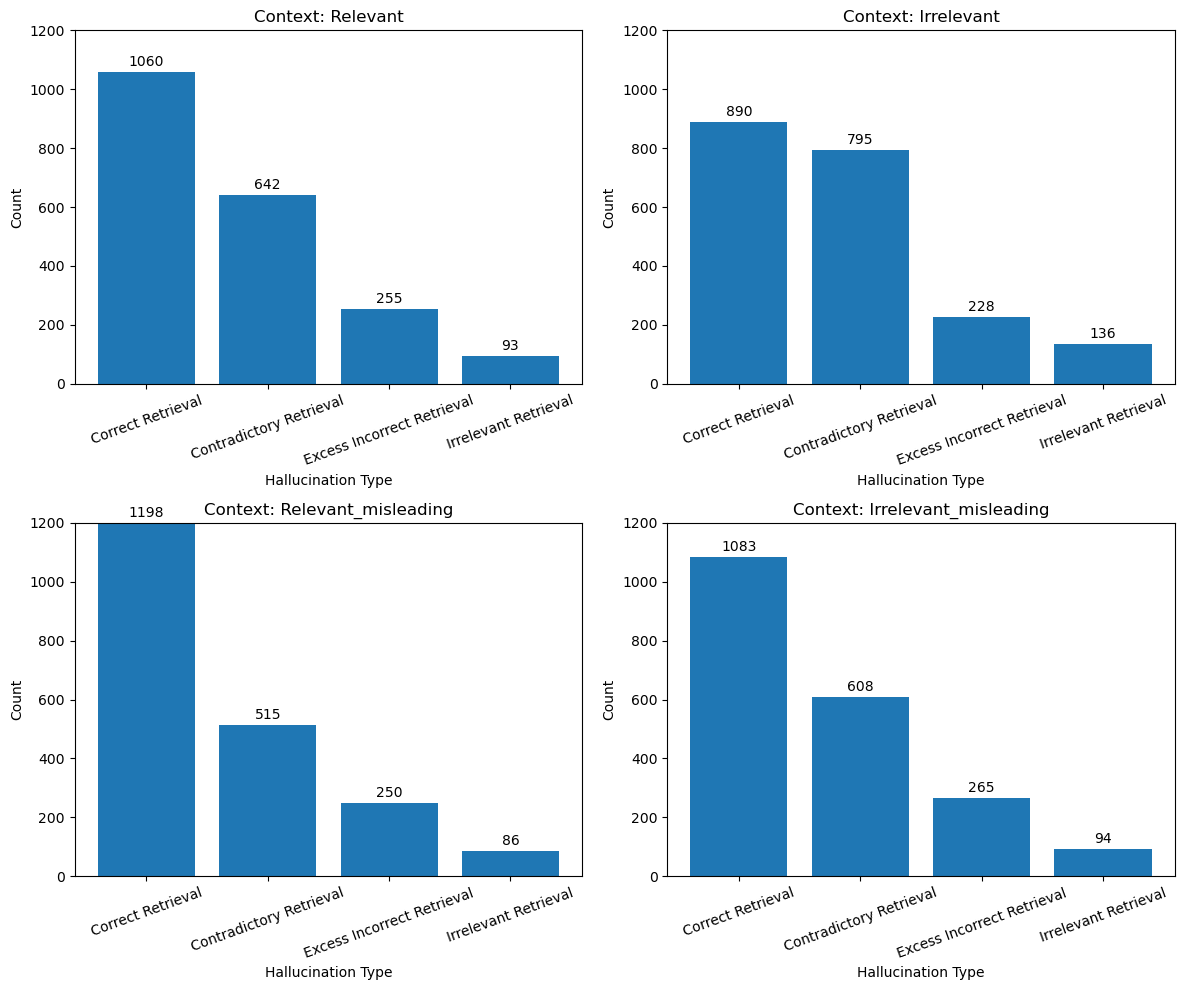

In [84]:
all_rows = []

for id in ids:
    try:
        with open(f"updated_unique_responses_block_top30/{id}.json", "r") as f:
            data = json.load(f)
            for category, entries in data.items():
                for entry in entries:
                    entry['context_category'] = category
                    entry['id'] = id
                    all_rows.append(entry)

    except FileNotFoundError:
            pass

df = pd.DataFrame(all_rows)
df['scores'] = df['hallucination_type'].apply(
    lambda x: 100.0 if x == 'Correct Retrieval' else 0.0
)

# row: depth, col: context length
depth_percentages_set = set(df['depth_percent'])
context_length_set = set(df['context_length'])

score_matrix = pd.DataFrame(0, index=sorted(list(depth_percentages_set)), columns=sorted(list(context_length_set)))

score_mean_matrices = {
    "irrelevant": score_matrix.copy(),
    "relevant": score_matrix.copy(),
    "relevant_misleading": score_matrix.copy(),
    "irrelevant_misleading": score_matrix.copy()
}

score_var_matrices = {
    "irrelevant": score_matrix.copy(),
    "relevant": score_matrix.copy(),
    "relevant_misleading": score_matrix.copy(),
    "irrelevant_misleading": score_matrix.copy()
}

bar_charts = {
    "relevant": None,
    "irrelevant": None,
    "relevant_misleading": None,
    "irrelevant_misleading": None
}
     
for context_key in score_mean_matrices.keys():
    bar_chart_df = df[df['context_category'] == context_key]
    hallucination_counts = bar_chart_df['hallucination_type'].value_counts().to_dict()
    bar_charts[context_key] = defaultdict(lambda: 0, hallucination_counts)
    
    for depth in depth_percentages_set:
        for context_length in context_length_set:
            filtered_df = df[(df['depth_percent'] == depth) & (df['context_length'] == context_length) & (df['context_category'] == context_key)]

            if not filtered_df.empty:
                avg_val = filtered_df['scores'].mean()
                # using population variance
                var_val = filtered_df['scores'].var(ddof=0)
                score_mean_matrices[context_key].loc[depth, context_length] = avg_val
                score_var_matrices[context_key].loc[depth, context_length] = var_val

# Assuming bar_charts has exactly 4 items
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows x 2 cols of subplots
axes = axes.flatten()  # Flatten to make it easier to loop through

for idx, (context_key, context_values) in enumerate(bar_charts.items()):
    ax = axes[idx]
    x_axis = ["Correct Retrieval", "Contradictory Retrieval", "Excess Incorrect Retrieval", "Irrelevant Retrieval"]
    bars = ax.bar(x_axis, [context_values[key] for key in x_axis])
    ax.set_xlabel("Hallucination Type")
    ax.set_ylabel("Count")
    ax.set_title("Context: " + context_key.capitalize())
    ax.tick_params(axis='x', rotation=20)
    ax.set_ylim(0, 1200)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 10, str(int(height)),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
bar_charts.keys()

dict_keys(['irrelevant', 'relevant', 'relevant_misleading', 'irrelevant_misleading'])

In [86]:
CONTEXTS = ['relevant', 'irrelevant', 'relevant_misleading', 'irrelevant_misleading']
dfs = [(context, pd.DataFrame(score_mean_matrices[context])) for context in CONTEXTS]
pivot_tables = []
for k, df in dfs:
    print(df)
    df = df.reset_index().melt(id_vars='index', var_name='context_length', value_name='score')
    df = df.rename(columns={'index': 'depth_percentage'})  
    print(df)
    pivot_table = pd.pivot_table(df, values='score', index=['depth_percentage', 'context_length'], aggfunc='mean').reset_index()
    pivot_table = pivot_table.pivot(index="depth_percentage", columns="context_length", values="score")
    pivot_tables.append((k, pivot_table))


            0          1250       2500       3750       5000
0.0    57.317073  31.707317  31.707317  31.707317  29.268293
25.0   57.317073  42.682927  45.121951  47.560976  48.780488
50.0   57.317073  46.341463  56.097561  47.560976  52.439024
75.0   58.536585  52.439024  54.878049  52.439024  46.341463
100.0  57.317073  68.292683  73.170732  73.170732  73.170732
    depth_percentage context_length      score
0                0.0              0  57.317073
1               25.0              0  57.317073
2               50.0              0  57.317073
3               75.0              0  58.536585
4              100.0              0  57.317073
5                0.0           1250  31.707317
6               25.0           1250  42.682927
7               50.0           1250  46.341463
8               75.0           1250  52.439024
9              100.0           1250  68.292683
10               0.0           2500  31.707317
11              25.0           2500  45.121951
12              50.0   

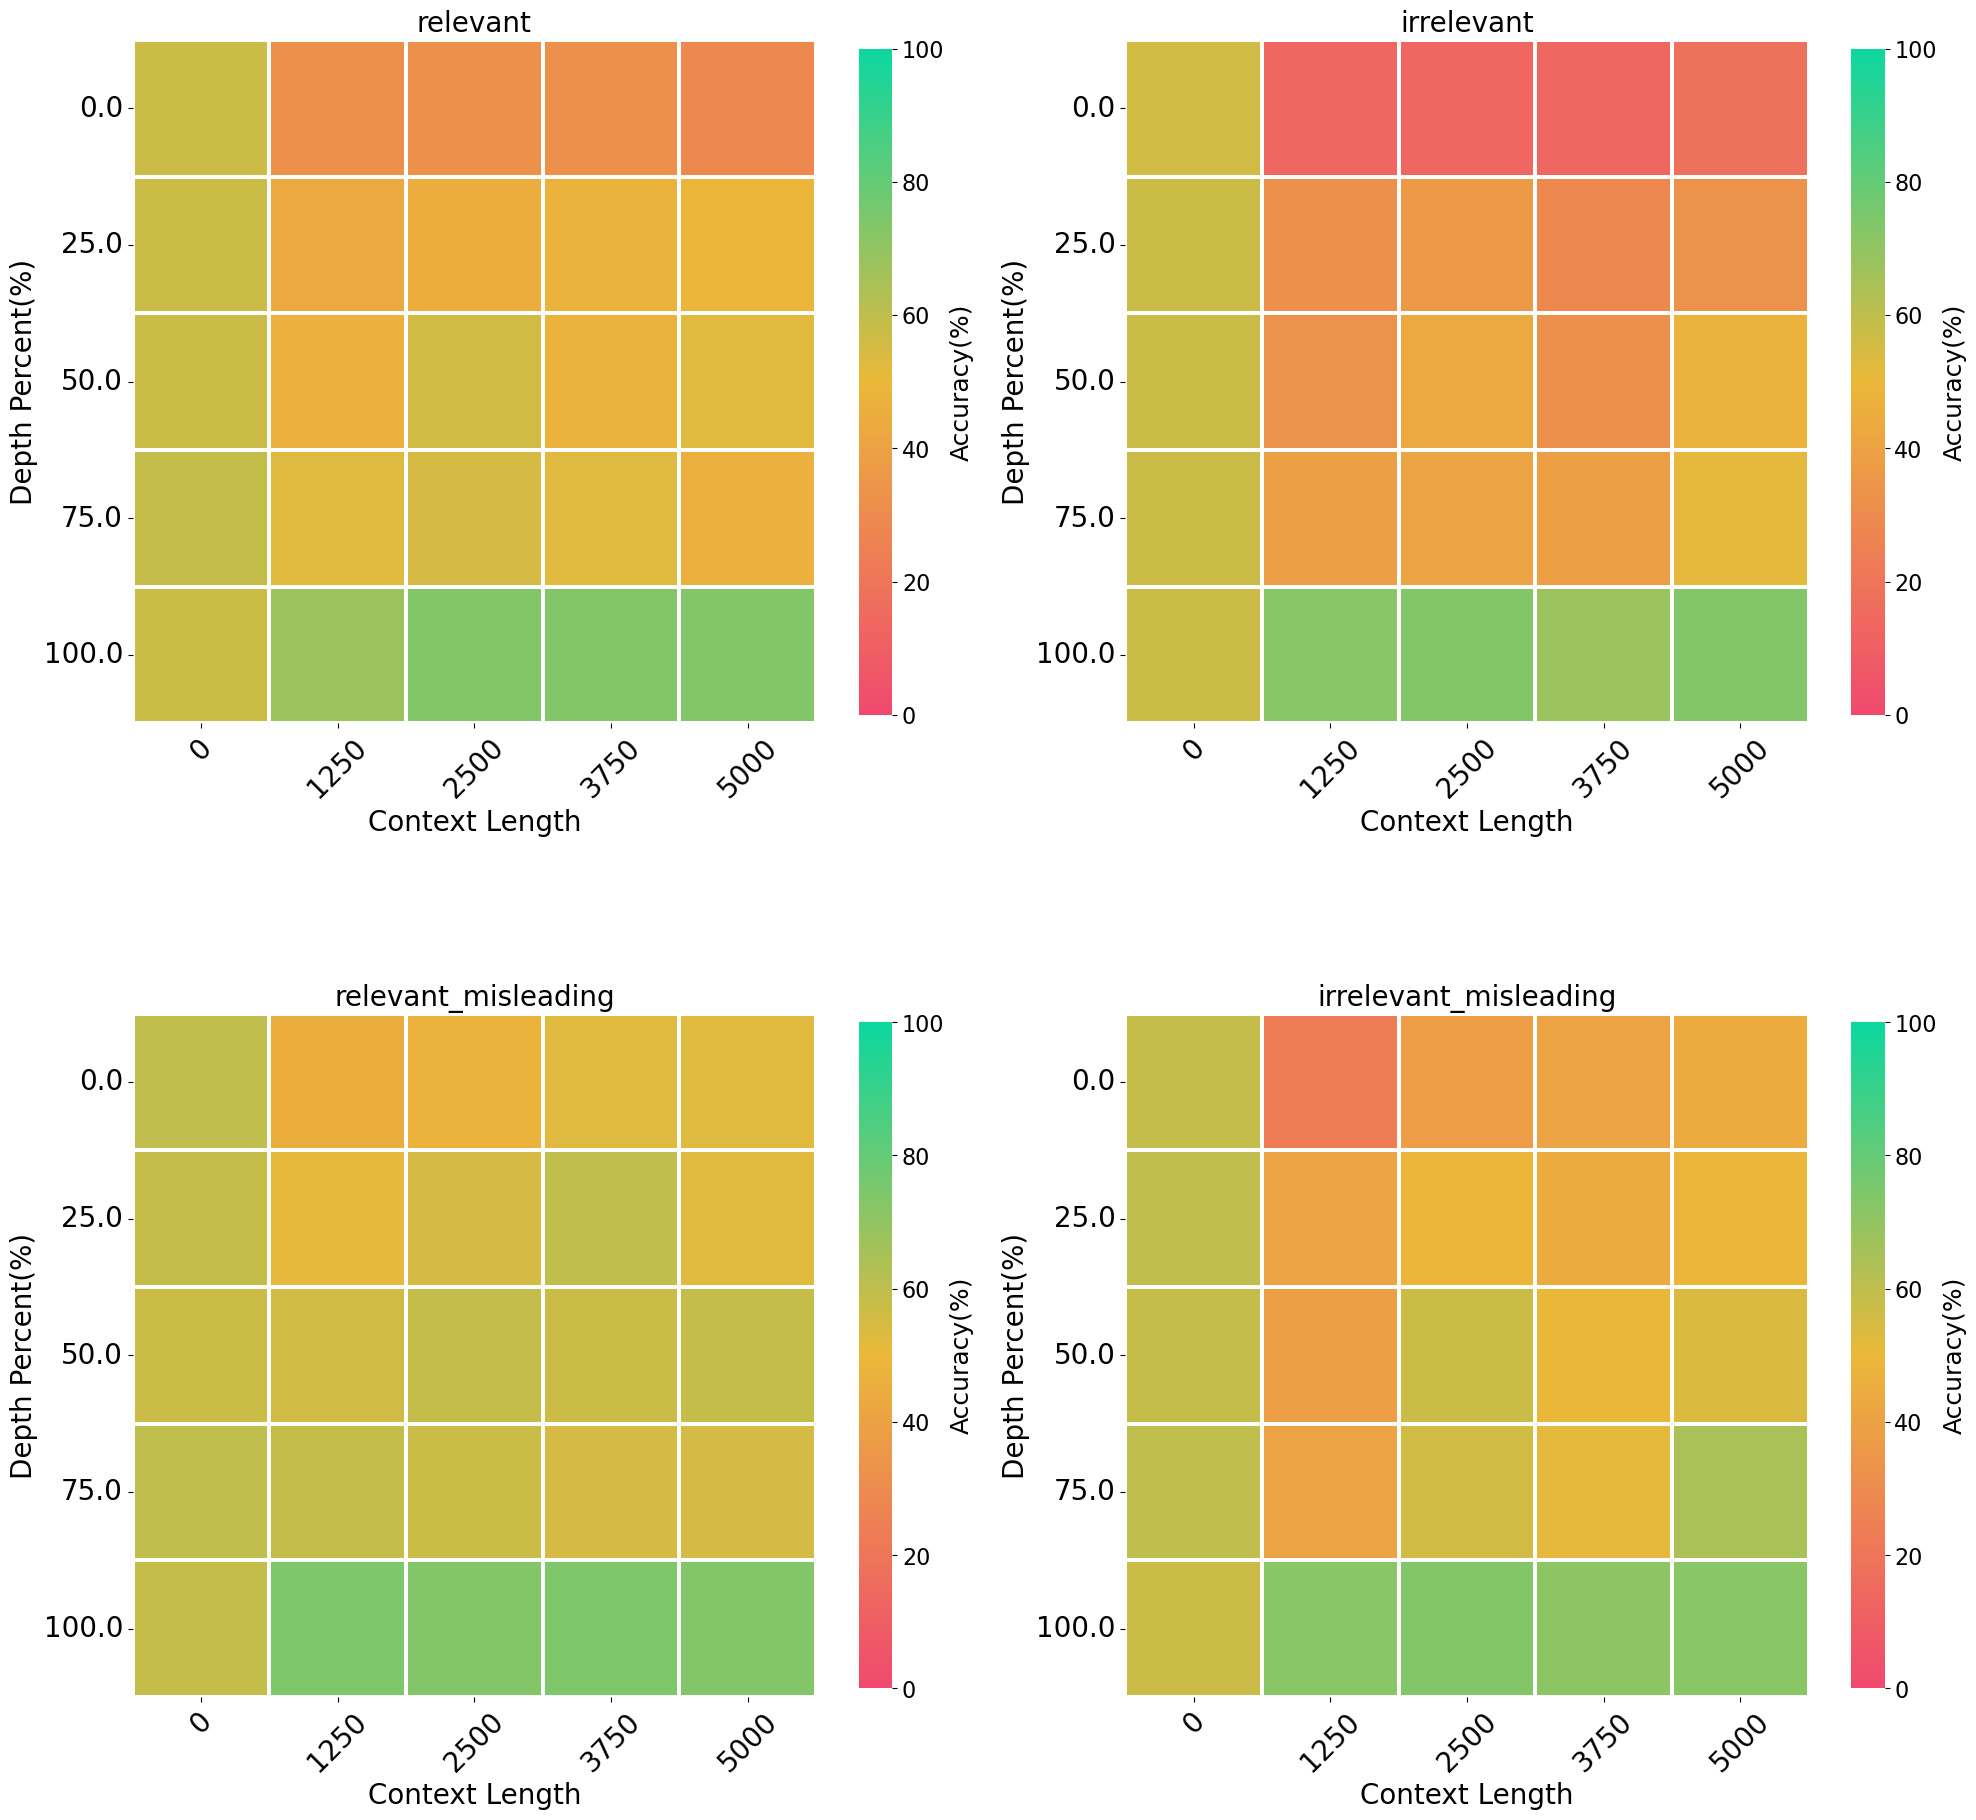

In [87]:
plt.figure(figsize=(20, 20))

for i, (title, data) in enumerate(pivot_tables, 1):
        
    plt.subplot(2, 2, i)
    cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])
    ax = sns.heatmap(
        data,
        cmap=cmap,
        vmin=0, 
        vmax=100,
        square=True,
        linewidths=1.5,             
        linecolor='white',
        cbar_kws={'label': 'Accuracy', 'shrink': 0.7})
    # Add a custom legend
    # legend_labels = ['No Hallucination', 'Hallucination']
    # colors = ['#0CD79F', '#F0496E']

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)  # Change tick font size
    cbar.set_label('Accuracy(%)', fontsize=18)

    # Create legend patches
    # patches_list = [patches.Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]
    # plt.legend(handles=patches_list, loc='upper left')
    plt.title(title, fontsize=20)
    plt.xlabel('Context Length', fontsize=20)
    plt.ylabel('Depth Percent(%)', fontsize=20)
    plt.xticks(rotation=45, fontsize=20)
    plt.yticks(rotation=0, fontsize=20)
    
    
plt.tight_layout()
plt.show()
